In [35]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
# Load audio
audio, sr = librosa.load('blorbs.wav', sr=22050)

#audio, sr = librosa.load('sauna test.wav', sr=22050)

/tmp/ipython-input-3697839025.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load('gracie abrams imyis.m4a', sr=22050)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


In [36]:
# Create spectrogram (no cropping needed!)
#spectrogram = librosa.stft(audio)
spectrogram = librosa.stft(audio, n_fft=1024, hop_length=256)
spectrogram_db = librosa.amplitude_to_db(abs(spectrogram))

In [37]:
########################### minimising loss
# After computing spectrogram_db
spec_min = spectrogram_db.min()
spec_max = spectrogram_db.max()
spectrogram_db = (spectrogram_db - spec_min) / (spec_max - spec_min)  # Now in [0, 1]


In [38]:
# Reverse later for visualization:
# reconstructed = reconstructed * (spec_max - spec_min) + spec_min


In [39]:
# Convert to tensor
spectrogram_tensor = torch.from_numpy(spectrogram_db).float()
spectrogram_tensor = spectrogram_tensor.unsqueeze(0).unsqueeze(0)  # [1,1,freq,time]


In [40]:
print("Input shape:", spectrogram_tensor.shape)

Input shape: torch.Size([1, 1, 513, 3440])


In [41]:
# Simple Model (no encoder-decoder)
class SpectrogramProcessor(nn.Module):
    def __init__(self):
        super().__init__()
        # Single convolutional layer that preserves dimensions
        self.layer = nn.Sequential(
            nn.Conv2d(1, 1, kernel_size=3, padding=1),  # Same input/output size
            nn.ReLU()
        )

    def forward(self, x):
        return self.layer(x)

In [42]:
# Initialize model
model = SpectrogramProcessor()
print("Model architecture:", model)

Model architecture: SpectrogramProcessor(
  (layer): Sequential(
    (0): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
)


In [43]:
# Verify input/output alignment
dummy_input = torch.randn(1, 1, 1025, 230)
output = model(dummy_input)
print("Output shape:", output.shape)  # Will match input shape!

Output shape: torch.Size([1, 1, 1025, 230])


In [44]:
# Training loop
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    optimizer.zero_grad()
    output = model(spectrogram_tensor)
    loss = criterion(output, spectrogram_tensor)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

Epoch 1/10, Loss: 0.0221
Epoch 2/10, Loss: 0.0220
Epoch 3/10, Loss: 0.0218
Epoch 4/10, Loss: 0.0217
Epoch 5/10, Loss: 0.0215
Epoch 6/10, Loss: 0.0213
Epoch 7/10, Loss: 0.0212
Epoch 8/10, Loss: 0.0210
Epoch 9/10, Loss: 0.0209
Epoch 10/10, Loss: 0.0207


In [45]:
# Save and visualize
torch.save(model.state_dict(), "simple_spectrogram_model.pth")
print("Training done! Model saved.")

Training done! Model saved.


In [46]:
# Plot results
with torch.no_grad():
    reconstructed = model(spectrogram_tensor).squeeze().numpy()

In [47]:
######## denormalise
reconstructed = reconstructed * (spec_max - spec_min) + spec_min

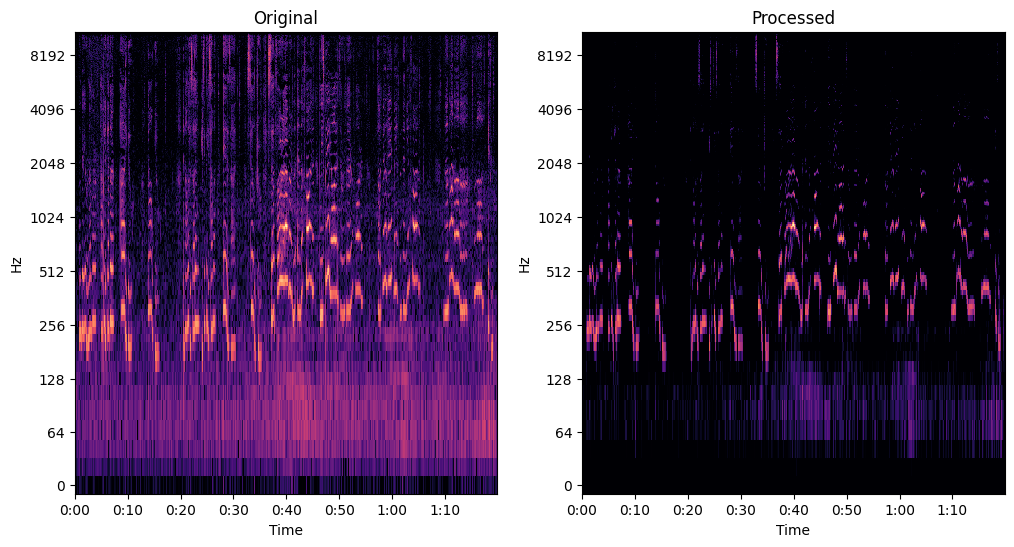

/tmp/ipython-input-516901340.py:20: UserWarning: PySoundFile failed. Trying audioread instead.
  clean_audio, sr = librosa.load('gracie abrams imyis.m4a', sr=22050)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Input (noisy) shape: torch.Size([1, 1, 513, 3440])
Target (clean) shape: torch.Size([1, 1, 513, 3440])
Model architecture: DenoisingAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(16, 8, kernel_size=(2, 2), stride=(2, 2), output_padding=(1, 0))
    (1): ReLU()
    (2): Conv2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)
Output shape: torch.Size([1, 1, 513, 3440])
Target shape: torch.Size([1, 1, 513, 3440])
Epoch 1/20, Loss: 0.0151
Output shape: torch.Size([1, 1, 513, 3440])
Target shape: torch.Size([1, 1, 513, 3440])
Epoch 2/20, Loss: 0.0150
Output shape: torch.Size([1, 1, 513, 3440])
Target shape: torch.Size([1, 1, 513, 3440])
Epoch 3/20, Loss: 0.0150
Output shape: 

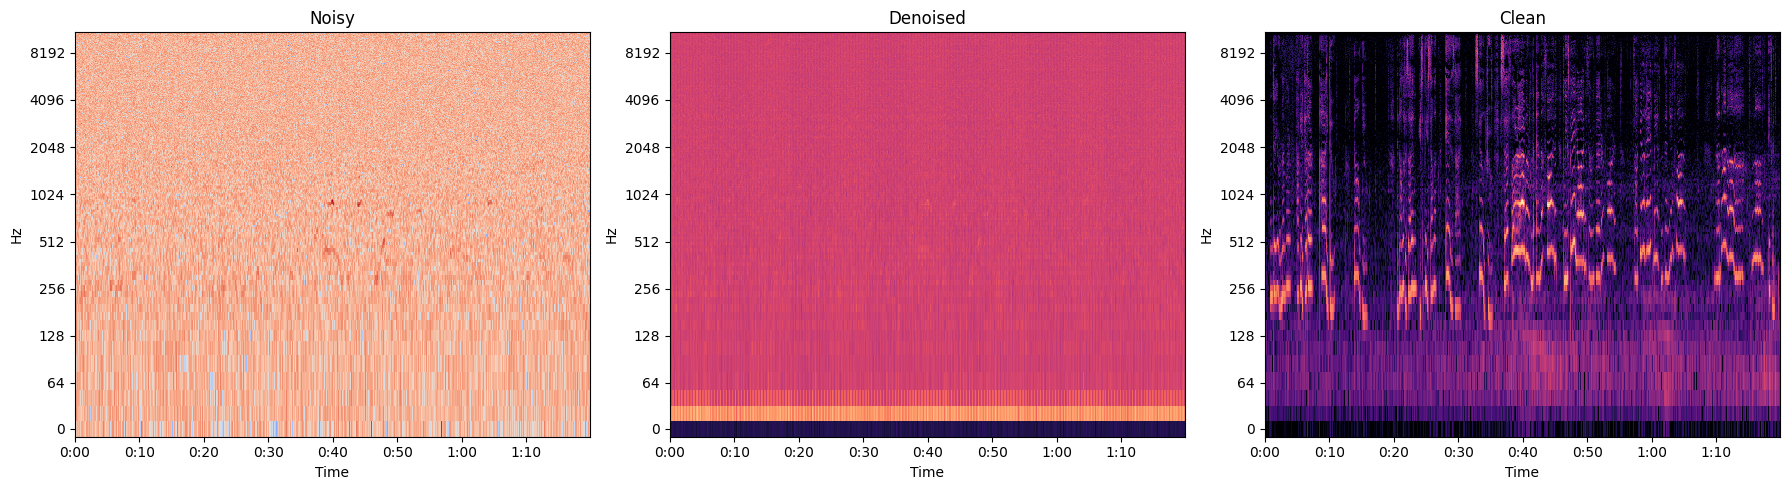

In [48]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
librosa.display.specshow(spectrogram_db, sr=sr, x_axis='time', y_axis='log')
plt.title('Original')

plt.subplot(1, 2, 2)
librosa.display.specshow(reconstructed, sr=sr, x_axis='time', y_axis='log')
plt.title('Processed')
plt.show()

#denoising
import librosa
import librosa.display
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np

# ----------- Step 1: Load Clean Audio and Create Noisy Version -----------
clean_audio, sr = librosa.load('gracie abrams imyis.m4a', sr=22050)

def add_noise(audio, noise_level=0.2):
    noise = np.random.normal(0, noise_level, audio.shape)
    return audio + noise

noisy_audio = add_noise(clean_audio, noise_level=0.2)

# ----------- Step 2: Convert to Spectrograms and Normalize -----------
n_fft = 1024
hop_length = 256

clean_spec = librosa.stft(clean_audio, n_fft=n_fft, hop_length=hop_length)
noisy_spec = librosa.stft(noisy_audio, n_fft=n_fft, hop_length=hop_length)

#####
# After computing clean_spec and noisy_spec:
freq_bins, time_steps = clean_spec.shape

# Convert to dB
clean_db = librosa.amplitude_to_db(np.abs(clean_spec))
noisy_db = librosa.amplitude_to_db(np.abs(noisy_spec))

# Use noisy's min/max for normalization
spec_min = noisy_db.min()
spec_max = noisy_db.max()

# Normalize BOTH spectrograms
clean_db_norm = (clean_db - spec_min) / (spec_max - spec_min)  # Added
noisy_db_norm = (noisy_db - spec_min) / (spec_max - spec_min)

clean_tensor = torch.from_numpy(clean_db_norm).float().unsqueeze(0).unsqueeze(0)
noisy_tensor = torch.from_numpy(noisy_db_norm).float().unsqueeze(0).unsqueeze(0)

print("Input (noisy) shape:", noisy_tensor.shape)
print("Target (clean) shape:", clean_tensor.shape)

# ----------- Step 3: Define Denoising Autoencoder Model -----------
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1), nn.ReLU(),
            nn.Conv2d(8, 16, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # Decoder with output_padding
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 8, 2, stride=2, output_padding=(1, 0)), # Adjusted output_padding based on common shape differences
            nn.ReLU(),
            nn.Conv2d(8, 1, 3, padding=1)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        # Calculate output_padding dynamically if needed, but starting with (1,0) is a common fix
        # expected_shape = x.shape
        # decoder_output_shape = self.decoder(encoded).shape
        # output_padding = (expected_shape[2] - decoder_output_shape[2], expected_shape[3] - decoder_output_shape[3])
        # print("Calculated output_padding:", output_padding)
        # self.decoder[0].output_padding = output_padding
        decoded = self.decoder(encoded)
        return decoded


model = DenoisingAutoencoder()
print("Model architecture:", model)

# ----------- Step 4: Train the Model -----------
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 20

for epoch in range(num_epochs):
    optimizer.zero_grad()
    output = model(noisy_tensor)
    print("Output shape:", output.shape) # Print output shape
    print("Target shape:", clean_tensor.shape) # Print target shape
    loss = criterion(output, clean_tensor)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

torch.save(model.state_dict(), "denoising_model.pth")
print("Training done! Model saved.")

# ----------- Step 5: Denoise and Visualize -----------
with torch.no_grad():
    denoised_tensor = model(noisy_tensor).squeeze().numpy()

# Denormalize
denoised_db = denoised_tensor * (spec_max - spec_min) + spec_min

plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
librosa.display.specshow(noisy_db, sr=sr, x_axis='time', y_axis='log')
plt.title('Noisy')
plt.subplot(1, 3, 2)
librosa.display.specshow(denoised_db, sr=sr, x_axis='time', y_axis='log')
plt.title('Denoised')
plt.subplot(1, 3, 3)
librosa.display.specshow(clean_db, sr=sr, x_axis='time', y_axis='log')
plt.title('Clean')
plt.tight_layout()
plt.show()